In [163]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
import sklearn.linear_model

In [164]:
lb = LabelBinarizer()

In [165]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [166]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [167]:
class NeuralNet:
    
    def __init__(self, hidden_layer_sizes, normalize = True, learning_rate = 0.01, num_iter = 30000, eps = 10**-2):
        self.layer_sizes = hidden_layer_sizes 
        self.layers_count = len(self.layer_sizes) + 1
        self.normalize = normalize 
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.eps = eps
        
        self.COST_APPEND_T = 1
        
    def __normalize(self, X, mean = None, std = None):
        m = mean
        if m is None:
            m = np.array([np.mean(X, axis=1)]).T
        s = std
        if s is None:
            s = np.array([np.std(X, axis=1)]).T
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):       
        ex = np.exp(Z)        
        return ex / np.sum(ex, axis=0, keepdims = True)
    
    def __initialize_parameters(self):
        self.parameters = {}
        n_i = self.layer_sizes
        for i in range(1, self.layers_count + 1):
            self.parameters[f"W{i}"] = np.random.randn(n_i[i], n_i[i - 1]) * np.sqrt(2/n_i[i - 1])
            self.parameters[f"b{i}"] = np.zeros((n_i[i], 1))
       
    def __forward_propagation(self, X):
        cache = {"A0" : X}
        for i in range(1, self.layers_count + 1):
            cache[f"Z{i}"] = np.dot(self.parameters[f"W{i}"], cache[f"A{i - 1}"]) + self.parameters[f"b{i}"]
            cache[f"A{i}"] = self.__softmax(cache[f"Z{i}"])

        return cache[f"A{self.layers_count}"], cache
        

    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        gradients = {}
        for i in reversed(range(1, self.layers_count + 1)):
            if i == self.layers_count:
                gradients[f"dZ{i}"] = cache[f"A{i}"] - Y
            else:
                dAi = np.dot(self.parameters[f"W{i + 1}"].T, gradients[f"dZ{i + 1}"])
                gradients[f"dZ{i}"] = np.multiply(dAi, cache[f"A{i}"] * (1 - cache[f"A{i}"]))
                
            gradients[f"dW{i}"] = (1/m) * np.dot (gradients[f"dZ{i}"], cache[f"A{i - 1}"].T)  
            gradients[f"db{i}"] = (1/m) * np.sum(gradients[f"dZ{i}"], axis = 1, keepdims = True)
                
        return gradients
    
    def __update_parameters(self, gradients):
        for i in range(1, self.layers_count + 1):
            dWi = gradients[f"dW{i}"]
            dbi = gradients[f"db{i}"]
            self.parameters[f"W{i}"] -= self.learning_rate * dWi
            self.parameters[f"b{i}"] -= self.learning_rate * dbi

    def fit(self, X_vert, Y_vert, print_cost = True):
        
        lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False) 
        lb.fit(Y_vert)
        X, Y = X_vert.T, lb.transform(Y_vert).T
        
        if self.normalize: #Normalize
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = [] #Costs log

        if(len(self.layer_sizes) - 1 != self.layers_count):
            self.layer_sizes.insert(0, X.shape[0]) #Input layer
            self.layer_sizes.append(Y.shape[0]) #Output layer
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            gradients = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(gradients)

            #OUTPUT
            if print_cost and i % 1000 == 0: #Print cost every 1000 iterations
                print("{}-th iteration: {}".format(i, cost))

            if i % self.COST_APPEND_T == 0: #Append cost every 1000 iterations
                costs.append(cost)
            
            if(i>=self.COST_APPEND_T*2):
                if(abs(costs[-1] - costs[-2]) < self.eps):
                    break

        #Plot costs
        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel(f"Iteration, *{self.COST_APPEND_T}")
            plt.show()
        

    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)    
        
        probabilities = self.__forward_propagation(X)[0]
        return probabilities.T
        
    def predict(self, X_vert):
        probs = self.predict_proba(X_vert)
        results_bin = (probs == probs.max(axis=1)[:, None]).astype(int)
        return results_bin


In [168]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y = True)

In [169]:
print(X)
print(X.shape)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.

In [170]:
print(y)
print(y.shape)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
(150,)


In [171]:
#Custom algorithm

In [172]:
custom_classifier = NeuralNet(hidden_layer_sizes=[4, 3, 2], normalize = True, learning_rate = 0.05, num_iter = 100000, eps=10**-15)

0-th iteration: 1.9198398896411797
1000-th iteration: 1.2139223008220064
2000-th iteration: 0.7226181385829656
3000-th iteration: 0.5593914929258894
4000-th iteration: 0.45333802691297803
5000-th iteration: 0.3834826086689932
6000-th iteration: 0.3372751181308639
7000-th iteration: 0.3044442818791935
8000-th iteration: 0.2796017433347269
9000-th iteration: 0.25998204478381687
10000-th iteration: 0.24402408985665586
11000-th iteration: 0.2307603364593581
12000-th iteration: 0.2195456947336256
13000-th iteration: 0.2099265556297509
14000-th iteration: 0.2015724163458994
15000-th iteration: 0.19423764053427553
16000-th iteration: 0.18773828403703943
17000-th iteration: 0.18193630874886016
18000-th iteration: 0.17672731133230277
19000-th iteration: 0.17203009790183146
20000-th iteration: 0.16777740972718816
21000-th iteration: 0.16390716511071846
22000-th iteration: 0.16035338097548055
23000-th iteration: 0.1570362302988184
24000-th iteration: 0.15385241610548617
25000-th iteration: 0.1506

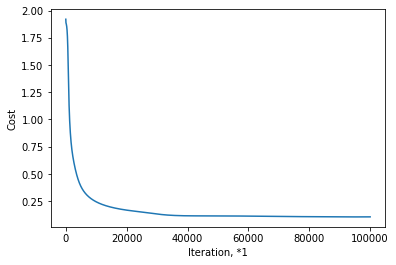

In [173]:
custom_classifier.fit(X, Y)

In [174]:
Y_probabilities = custom_classifier.predict_proba(X)
Y_probabilities

array([[9.99197183e-01, 8.02817337e-04, 2.04716568e-12],
       [9.97171488e-01, 2.82851188e-03, 2.46606860e-11],
       [9.99197129e-01, 8.02871466e-04, 2.04743835e-12],
       [9.99192594e-01, 8.07406253e-04, 2.07034541e-12],
       [9.99197243e-01, 8.02757331e-04, 2.04686343e-12],
       [9.99197167e-01, 8.02832506e-04, 2.04724209e-12],
       [9.99197274e-01, 8.02725962e-04, 2.04670543e-12],
       [9.99197197e-01, 8.02802680e-04, 2.04709185e-12],
       [8.35995889e-01, 1.64004023e-01, 8.88058033e-08],
       [9.99191866e-01, 8.08134028e-04, 2.07403342e-12],
       [9.99197106e-01, 8.02893898e-04, 2.04755135e-12],
       [9.99197256e-01, 8.02743661e-04, 2.04679458e-12],
       [9.98895059e-01, 1.10494084e-03, 3.84771384e-12],
       [9.99181220e-01, 8.18780442e-04, 2.12835490e-12],
       [9.99196868e-01, 8.03132008e-04, 2.04875104e-12],
       [9.99197199e-01, 8.02800516e-04, 2.04708095e-12],
       [9.99197135e-01, 8.02865181e-04, 2.04740669e-12],
       [9.99197160e-01, 8.02840

In [175]:
y_hat = custom_classifier.predict(X)
y_hat = np.array(lb.fit(y).inverse_transform(y_hat))
y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [176]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [177]:
accuracy = accuracy_score(y, y_hat)
accuracy

0.98